In [87]:
import utils, r_pca, wtt, wrappers

import os
import numpy as np
from skimage.measure import block_reduce
import pywt

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


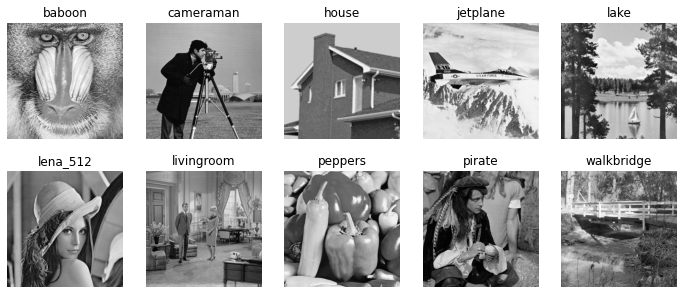

In [88]:
data_dirname = 'data'
data_filename = 'monochrome10.npz'

data = np.load(os.path.join(data_dirname, data_filename))

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(12, 5))
cnt = 0
for x in data:
    i, j = cnt // ncols, cnt % ncols
    ax[i, j].imshow(data[x], cmap='gray')
    ax[i, j].set_title(x)
    ax[i, j].set_axis_off()
    cnt += 1
plt.show()

In [89]:
objects = list(data.keys())
dataset = np.array([data[x] for x in objects])
dataset.shape

(10, 512, 512)

Делаем downsampling во имя производительности.

In [90]:
downsampling_scale = 2
d = 9 - downsampling_scale
n = 2 ** d
block_size = (2 ** downsampling_scale, 2 ** downsampling_scale)

dataset_new = np.empty((10, n, n), dtype=dataset.dtype)
for i in range(10):
    dataset_new[i] = np.round(block_reduce(dataset[i], block_size, np.mean))

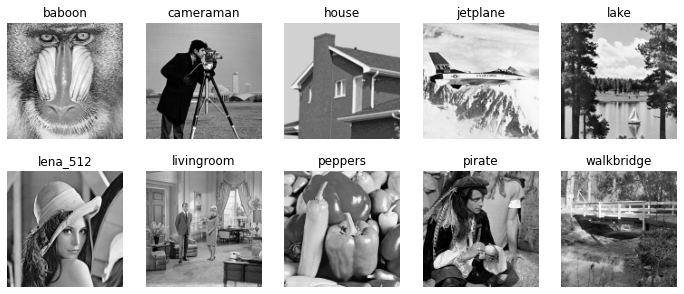

In [91]:
nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(12, 5))
cnt = 0
for x in data:
    i, j = cnt // ncols, cnt % ncols
    ax[i, j].imshow(dataset_new[cnt], cmap='gray')
    ax[i, j].set_title(x)
    ax[i, j].set_axis_off()
    cnt += 1
plt.show()

Анализ преобразования:
* Выполняем преобразование, получаем коэффициенты
* Перебираем значение порога $\delta$, для каждого $\delta$ считаем compress ratio. В статье Харюка 2014 года определение такое: $\frac{N^{nz}_w}{N_w}$ (отношение количества ненулевых элементов к общему количеству элементов), но это не очень логично и не реалистично (если судить по приведённым в статье графикам). Лучше будем использовать $\frac{N_w}{N^{nz}_w}$. Скажем, $CR=5$ означает, что мы сжали в 5 раз, и действительно: раньше у нас было $5n$ значений, а теперь лишь $n$ ненулевых. Так как у нас есть параметр сжатия $\delta$, то ненулевые значения у нас --- это те, которые больше $\delta$ по модулю.
* Все элементы, которые не больше $\delta$ по модулю, зануляем. Восстанавливаем обратным преобразованием картинку из сжатых коэффициентов.
* Считаем меру качества. PSNR для изображений хорошо подходит.
* Для разных дельт у нас 2 массива --- значения CR и значения PSNR. Строим график PSNR от CR. Собственно, дизайн эксперимента такой же, как в статье 2014 года.

$\delta$ растёт --- $CR$ растёт, так как мы не нулями считаем меньше элементов (а $CR$ ему обратно пропорционален). Также растёт ошибка (зануляем больше) и, соответственно, $PSNR$ падает.

Хотим: $CR$ побольше и $PSNR$ побольше.

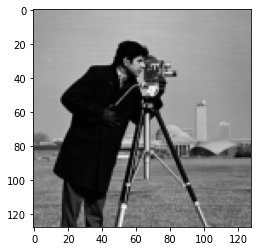

In [92]:
original = dataset_new[1]
plt.imshow(original, cmap='gray')

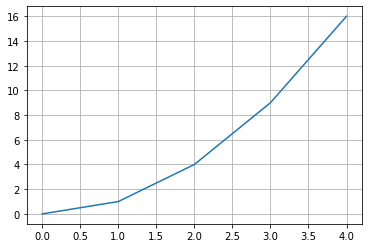

In [93]:
plt.plot(np.arange(5), np.arange(5) ** 2)
plt.grid()
plt.show()

In [94]:
modes = [2] * d

eps = 8e-2
lambda_scale=1.5

In [95]:
def experiment(
    original_num,
    eps_for_wtt,
    lambda_scale
):
    original = dataset_new[original_num]
    
    db_names = ['db2', 'db4', 'db6']
    dbs = [pywt.Wavelet(name) for name in db_names]
    wtt_classic = wrappers.WTTwrapper(1) #классика
    wtt_rpca_1 = wrappers.WTTwrapper(2) #просто RPCA вместо SVD
    wtt_rpca_2 = wrappers.WTTwrapper(3) #RPCA с сохранением sparse-частей

    algs = [
        wtt_classic,
        wtt_rpca_1,
        wtt_rpca_2
    ]

    for w in algs:
        w.adjust(
            original,
            d,
            modes,
            eps=eps,
            lambda_scale=lambda_scale,
            is_2D=True
        )

    preproc = wrappers.RPCA_preprocessing_wrapper(2)
    wtt_for_preproc = wrappers.WTTwrapper(1)

    vector, vector_modes = utils.matrix_to_vector(original, d, modes)
    l, s, r = preproc.adjust(
        vector,
        d,
        vector_modes,
        lambda_scale=lambda_scale,
        max_iter=150
    )
    l_matrix = utils.vector_to_matrix(l, d, vector_modes)[0]

    wtt_for_preproc.adjust(l_matrix, d, modes, ranks=r, eps=eps, is_2D=True)
    algs.append(wtt_for_preproc)

    deltas = np.linspace(1e-2, 1e2, 200)

    CR = [
        [[] for _ in range(len(dbs) + len(algs))] for _ in range(dataset_new.shape[0])
    ]
    PSNR = [
        [[] for _ in range(len(dbs) + len(algs))] for _ in range(dataset_new.shape[0])
    ]

    for cnt in range(10):
        original = dataset_new[cnt]
        coeffs_db = []
        coeffs = []
        for db in dbs:
            coeffs_db.append(pywt.wavedec2(original, db, mode='periodic'))
        for w in algs:
            coeffs.append(w.apply(original, is_2D=True))

        for delta in deltas:
            for i in range(len(dbs)):
                arr, slc = pywt.coeffs_to_array(coeffs_db[i])        
                thresholded = pywt.threshold(arr, delta, mode='hard')
                nnz = np.count_nonzero(thresholded)
                if nnz == 0:
                    print('div by zero in cr')
                    print('dbs, number=', i, 'delta=', delta)
                CR[cnt][i].append(thresholded.size * 1.0 / nnz)

                restored_coeffs = pywt.array_to_coeffs(thresholded, slc, output_format='wavedec2')
                restored = pywt.waverec2(restored_coeffs, dbs[i], mode='periodic')
                if nnz == original.size:
                    print('div by zero in psnr')
                    print('dbs, number=', i, 'delta=', delta)
                psnr_value = utils.psnr(original, restored)
                PSNR[cnt][i].append(psnr_value)

            for i in range(len(algs)):
                j = i + len(dbs)
                thresholded = pywt.threshold(coeffs[i], delta, mode='hard')
                nnz = np.count_nonzero(thresholded)
                if nnz == 0:
                    print('div by zero in cr')
                    print('wtts, number =', i, 'delta=', delta)
                CR[cnt][j].append(original.size * 1.0 / nnz)

                restored = algs[i].apply_inverse(thresholded, is_2D=True)
                if nnz == original.size:
                    print('div by zero in psnr')
                    print('wtts, number =', i, 'delta=', delta)
                psnr_value = utils.psnr(original, restored)
                PSNR[cnt][j].append(psnr_value)

    return CR, PSNR

In [137]:
def plot_results(original_num, CR, PSNR, window=(0,199), logscales=False, algs_to_plot=list(range(7)), shape=None, noisy=False):
    nrows, ncols = 2, 5
    fig, ax = plt.subplots(nrows, ncols, figsize=(18, 9))
    cnt = 0
    db_names = ['db2', 'db4', 'db6']
    alg_names = db_names + ['classic wtt', 'rpca_v1', 'rpca_v2', 'wtt for low-rank part']
    name = ''
    for x in data:
        if cnt == original_num:
            name = x
        
        c1, c2 = cnt // ncols, cnt % ncols
        for i in range(len(alg_names)):
            if i in algs_to_plot:
                s = '-' if shape is None else shape[i]
                ax[c1, c2].plot(CR[cnt][i][window[0]:window[1]], PSNR[cnt][i][window[0]:window[1]], s, label=alg_names[i])
        if logscales:
            ax[c1, c2].set_xscale('log')
            ax[c1, c2].set_yscale('log')
        ax[c1, c2].set_title(x)
        ax[c1, c2].grid()
        cnt += 1
    if noisy is True:
        fig.suptitle('Different wavelet transforms; wtt and its variants are trained on noisyfied ' + name, fontsize=16)
    else:
        fig.suptitle('Different wavelet transforms; wtt and its variants are trained on ' + name, fontsize=16)
    fig.text(0.5, 0.04, "Compress Ratio", fontsize=12, color='black', ha='center')
    fig.text(0.04, 0.5, "PSNR", fontsize=12, color='black', va='center', rotation='vertical')
    plt.legend(bbox_to_anchor=(2, 1.2))
    plt.show()

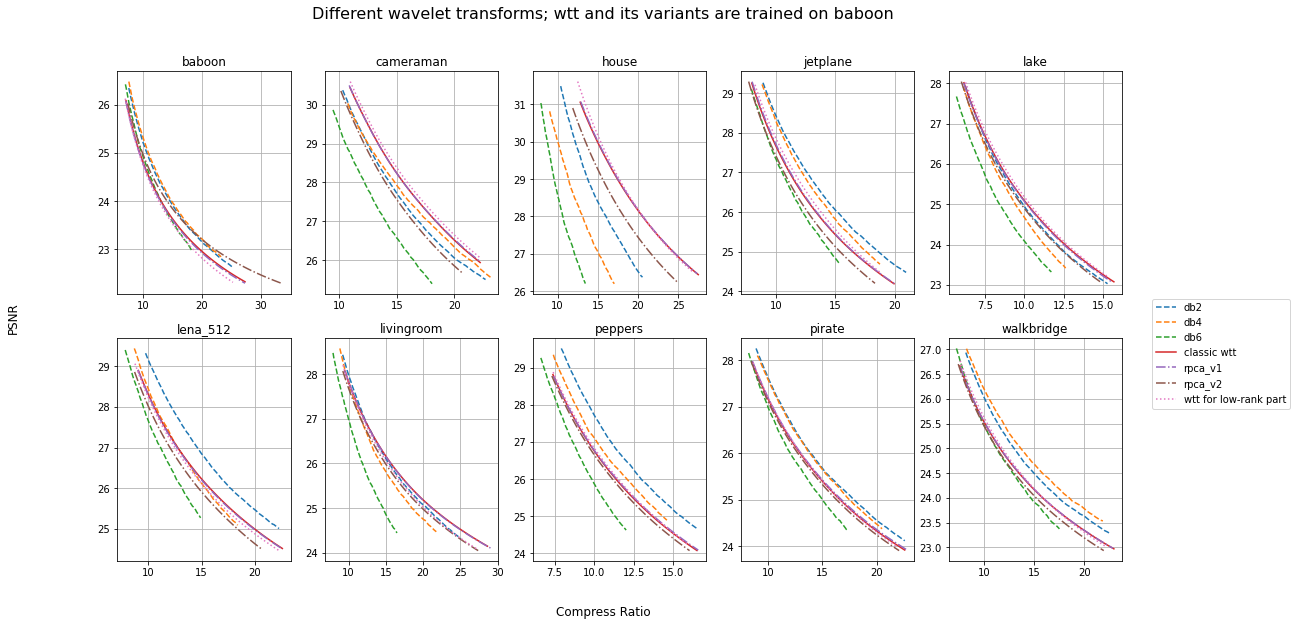

In [111]:
orig = 0
CR, PSNR = experiment(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], shape=['--','--','--','-','-.','-.',':'])

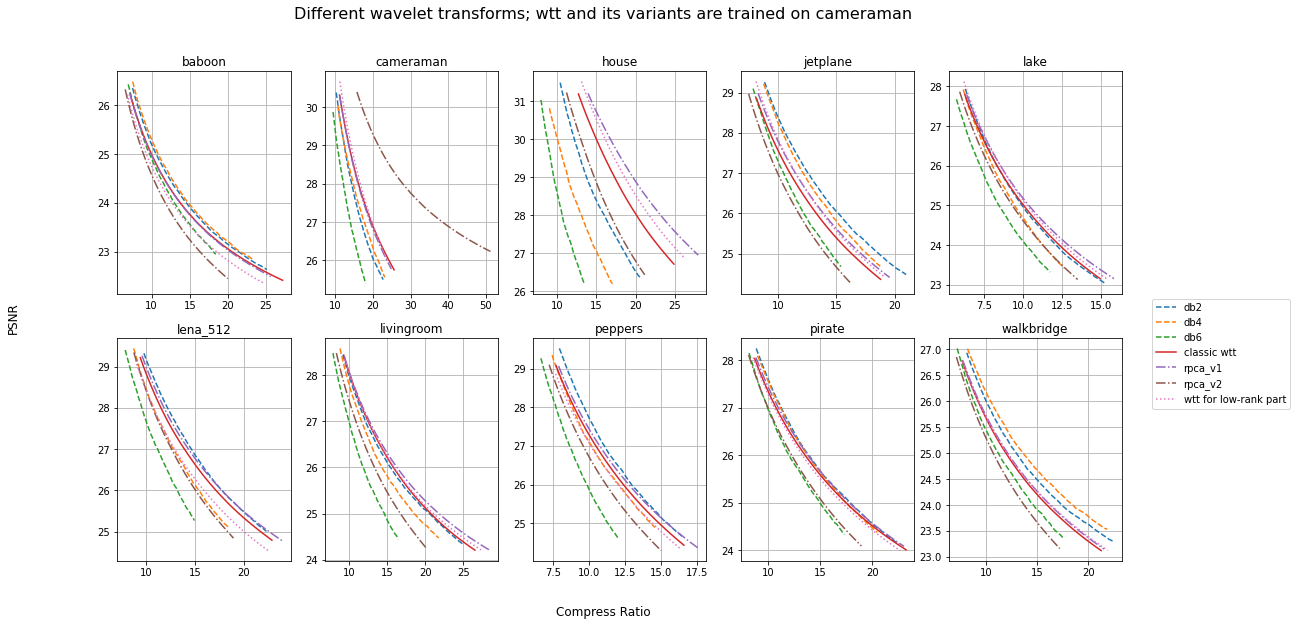

In [112]:
orig = 1
CR, PSNR = experiment(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], shape=['--','--','--','-','-.','-.',':'])

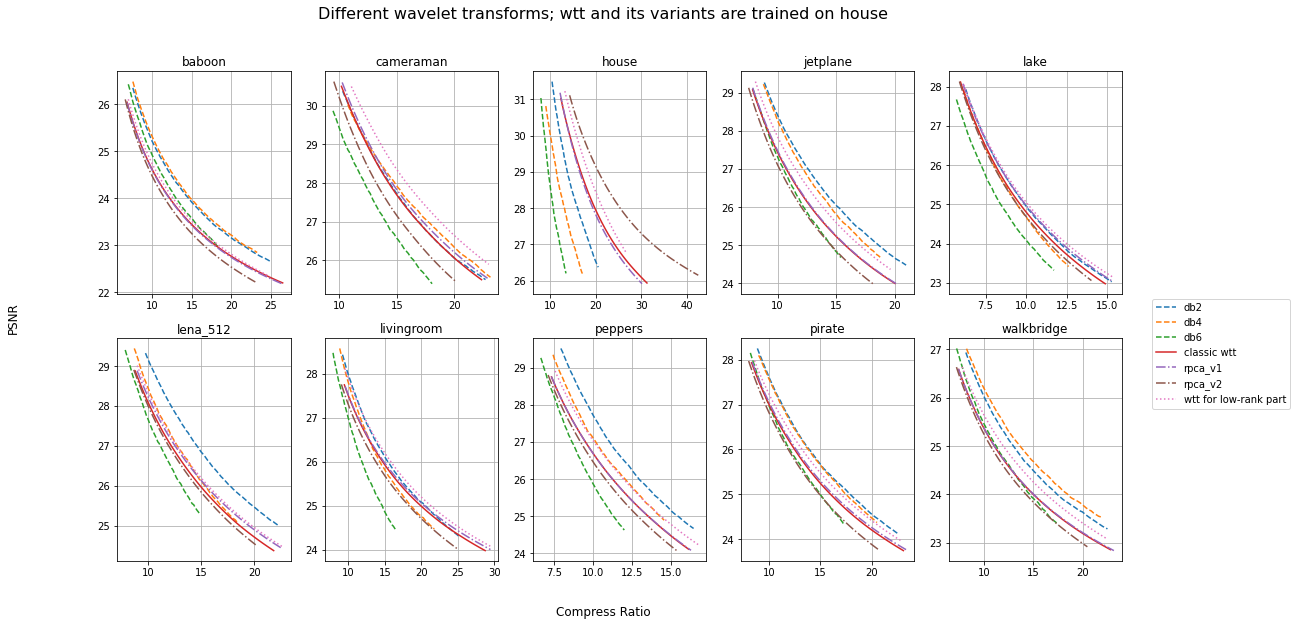

In [113]:
orig = 2
CR, PSNR = experiment(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], shape=['--','--','--','-','-.','-.',':'])

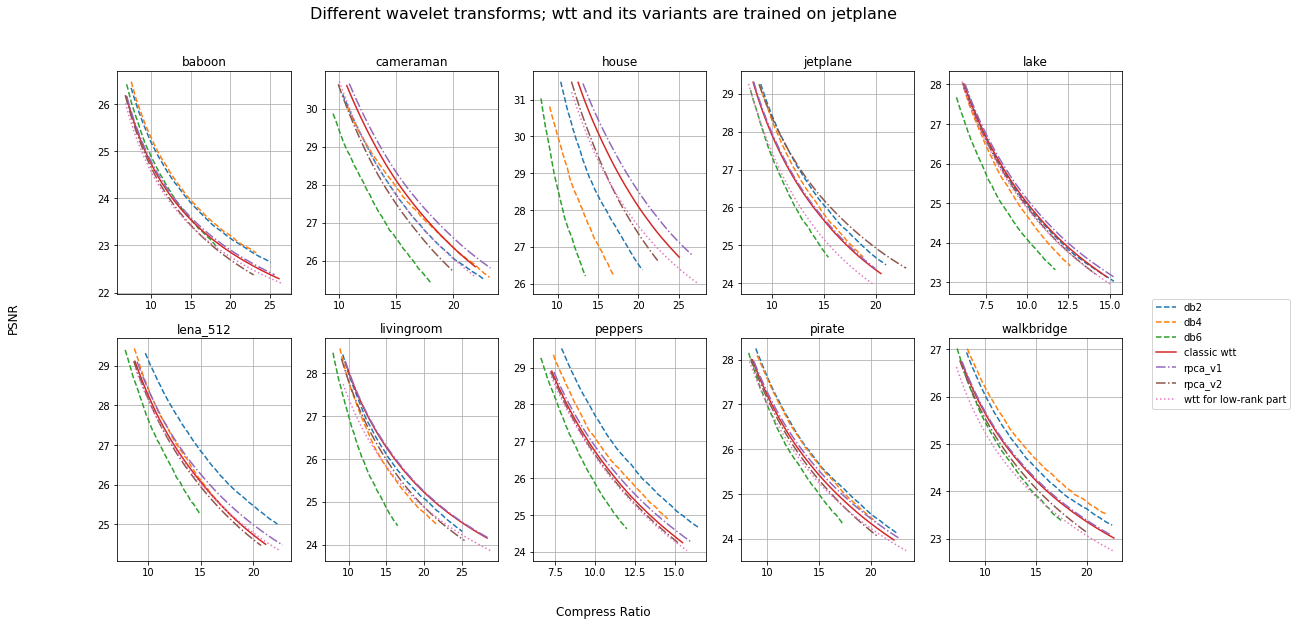

In [114]:
orig = 3
CR, PSNR = experiment(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], shape=['--','--','--','-','-.','-.',':'])

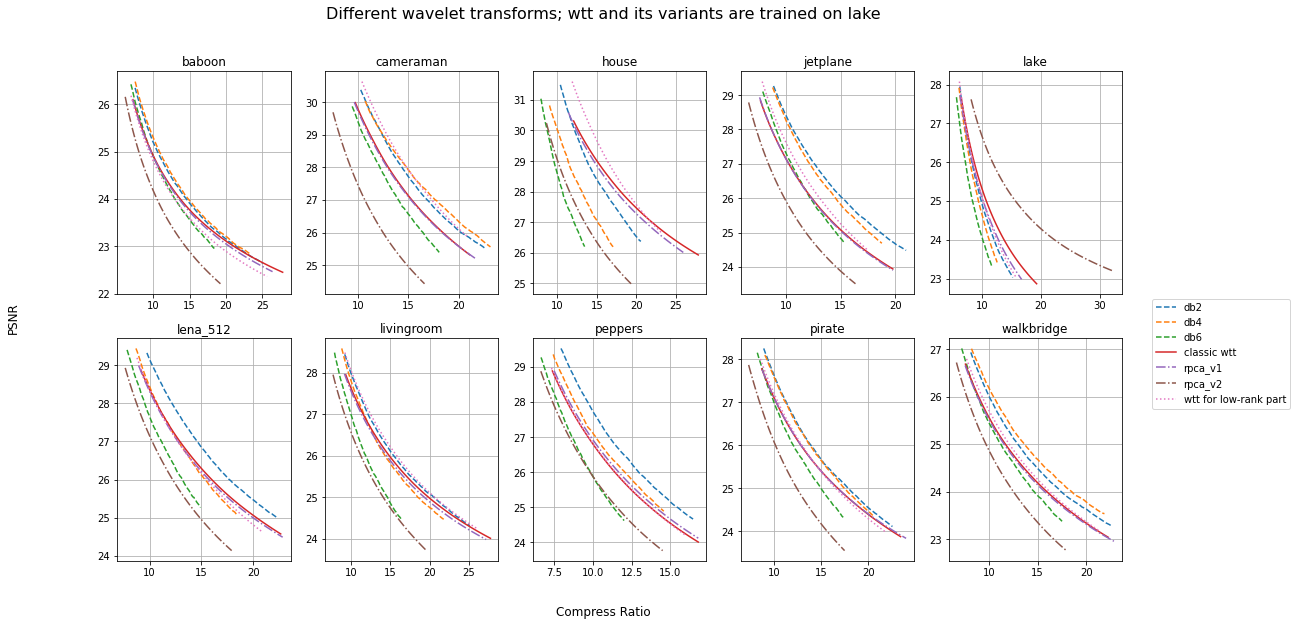

In [115]:
orig = 4
CR, PSNR = experiment(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], shape=['--','--','--','-','-.','-.',':'])

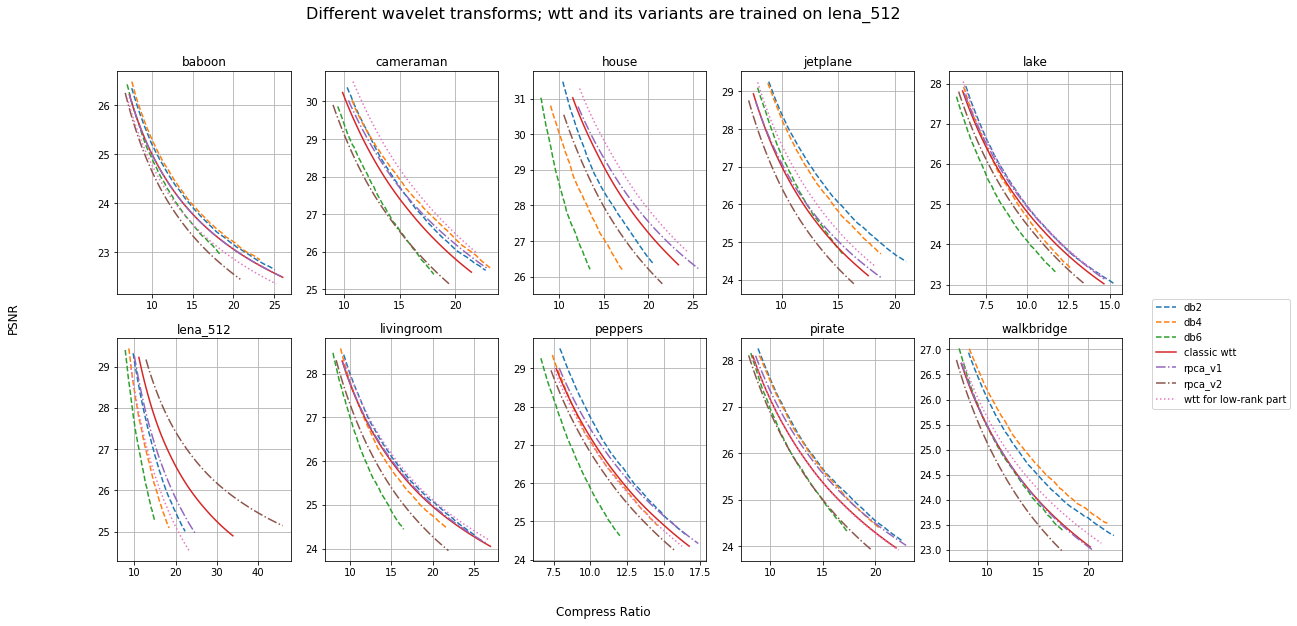

In [116]:
orig = 5
CR, PSNR = experiment(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], shape=['--','--','--','-','-.','-.',':'])

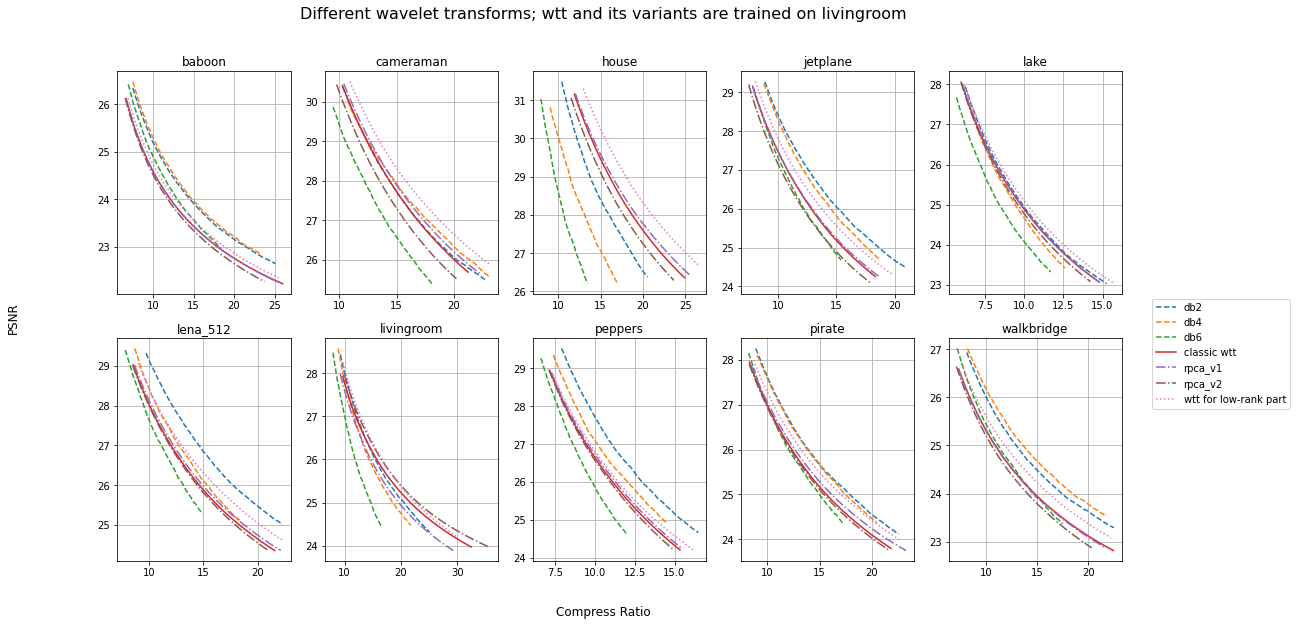

In [117]:
orig = 6
CR, PSNR = experiment(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], shape=['--','--','--','-','-.','-.',':'])

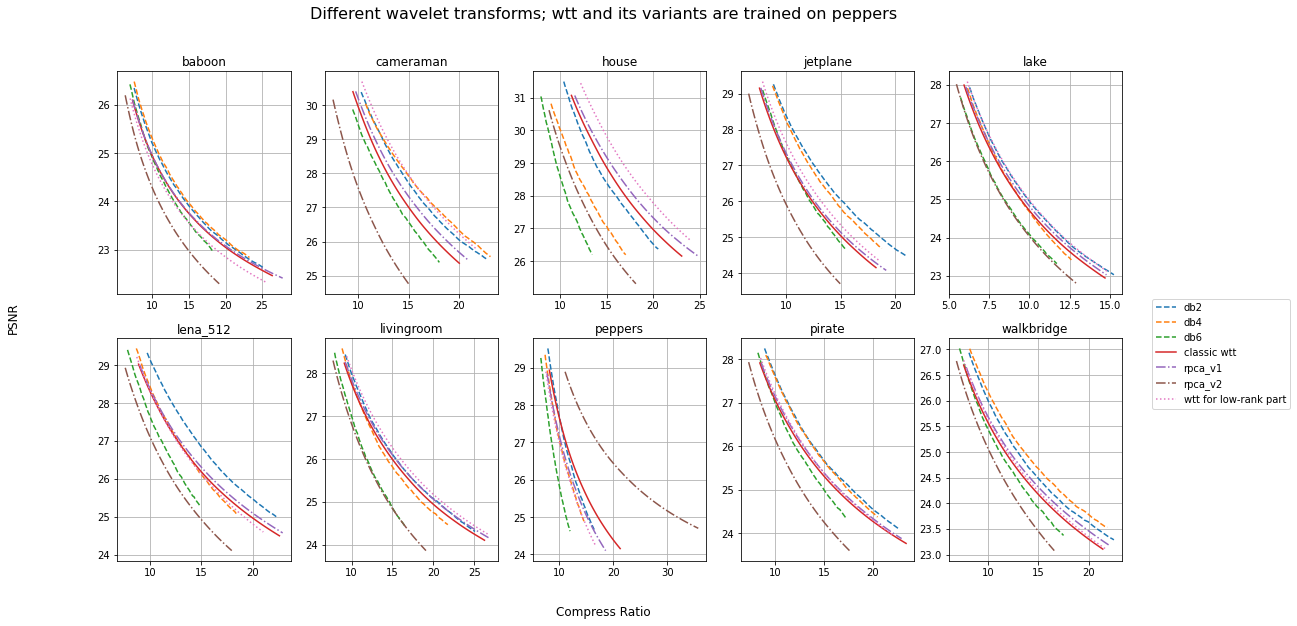

In [118]:
orig = 7
CR, PSNR = experiment(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], shape=['--','--','--','-','-.','-.',':'])

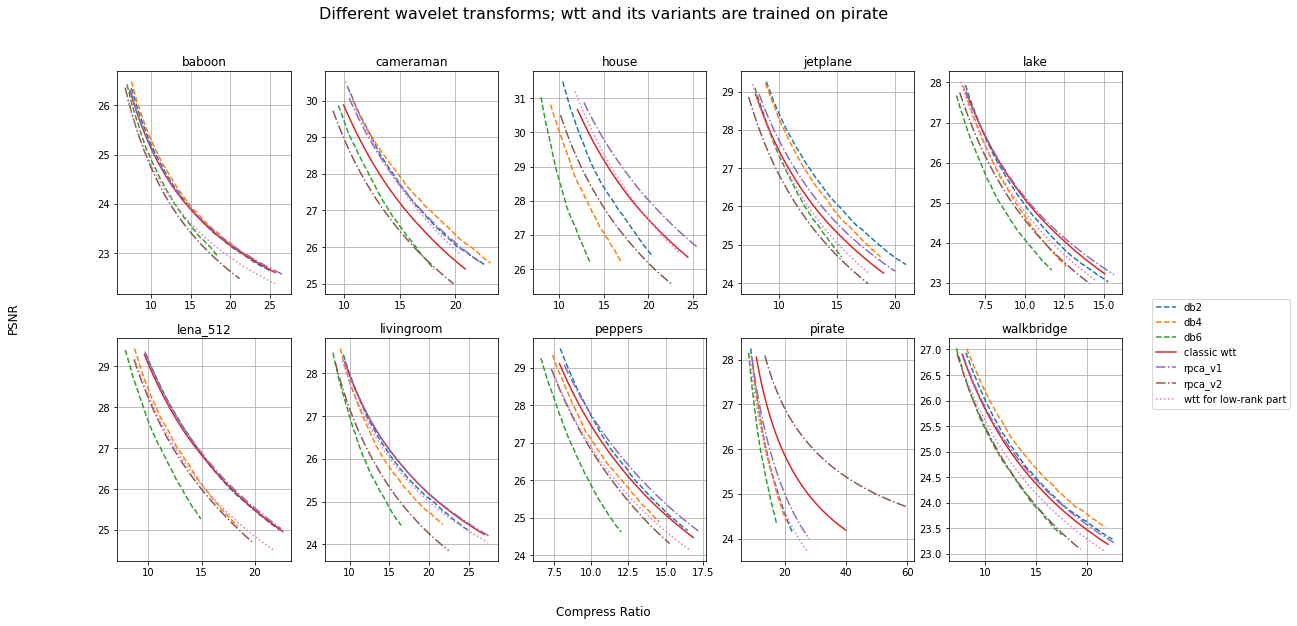

In [119]:
orig = 8
CR, PSNR = experiment(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], shape=['--','--','--','-','-.','-.',':'])

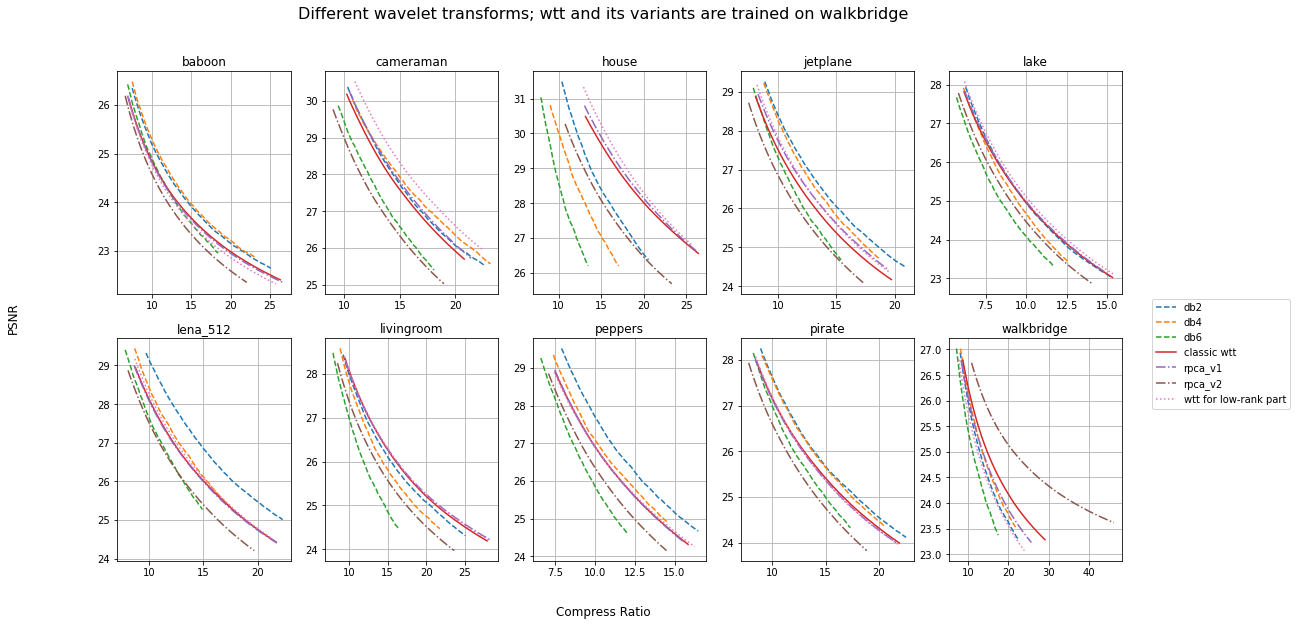

In [120]:
orig = 9
CR, PSNR = experiment(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], shape=['--','--','--','-','-.','-.',':'])

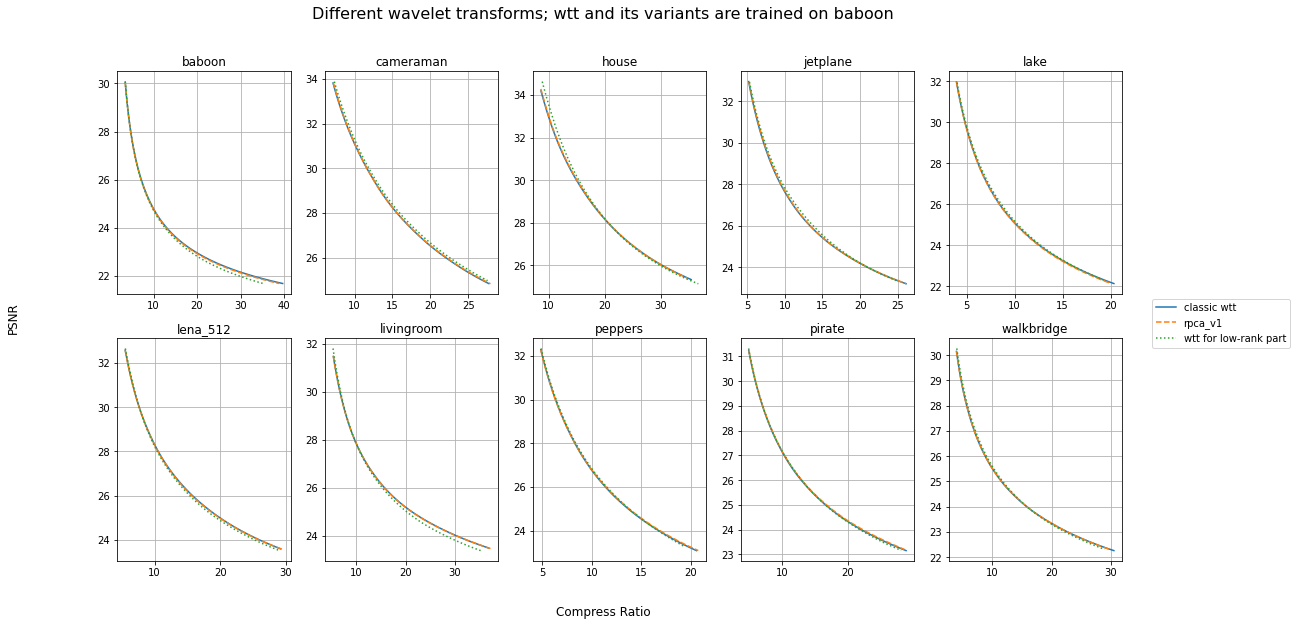

In [121]:
CR, PSNR = experiment(0, eps, lambda_scale)
plot_results(0, CR, PSNR, window=[40, 160], algs_to_plot=[3, 4, 6], shape=[0,0,0,'-','--',0,':'])

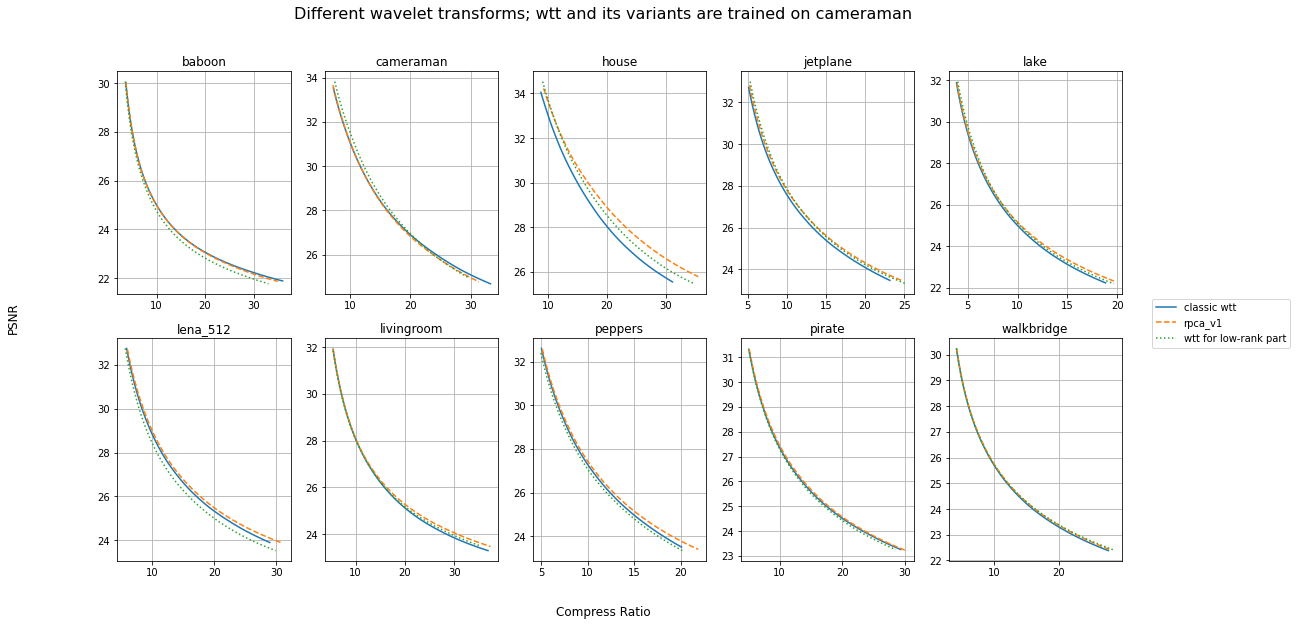

In [122]:
CR, PSNR = experiment(1, eps, lambda_scale)
plot_results(1, CR, PSNR,  window=[40, 160], algs_to_plot=[3, 4, 6], shape=[0,0,0,'-','--',0,':'])

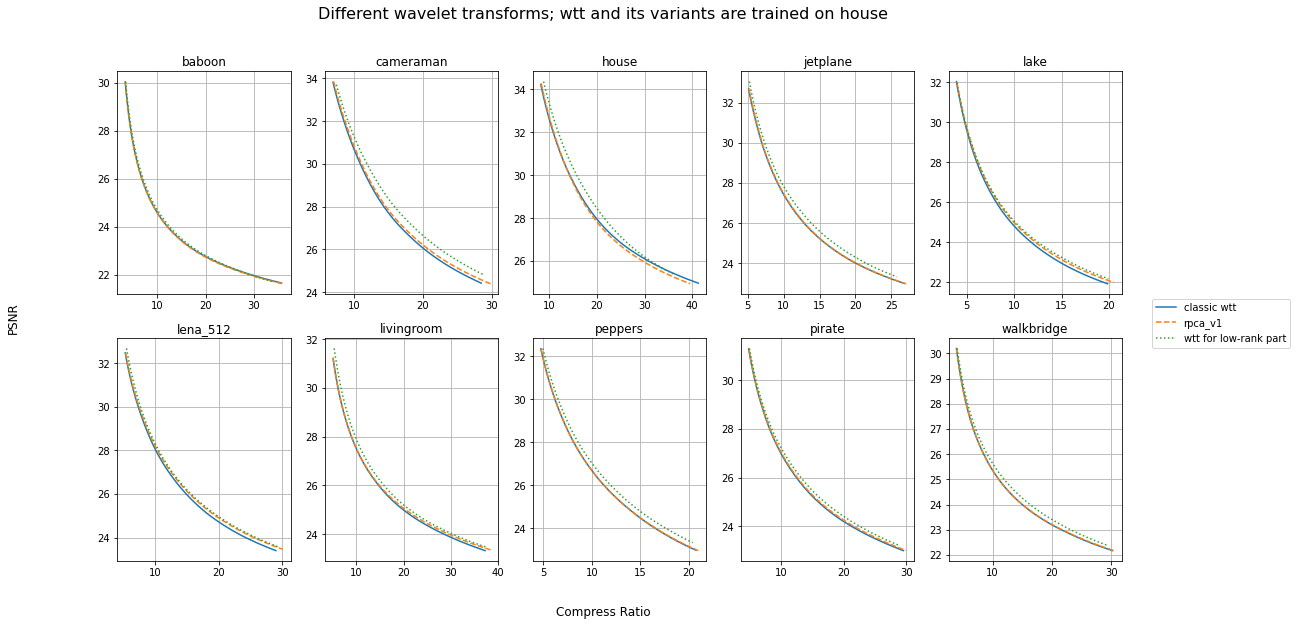

In [123]:
CR, PSNR = experiment(2, eps, lambda_scale)
plot_results(2, CR, PSNR,  window=[40, 160], algs_to_plot=[3, 4, 6], shape=[0,0,0,'-','--',0,':'])

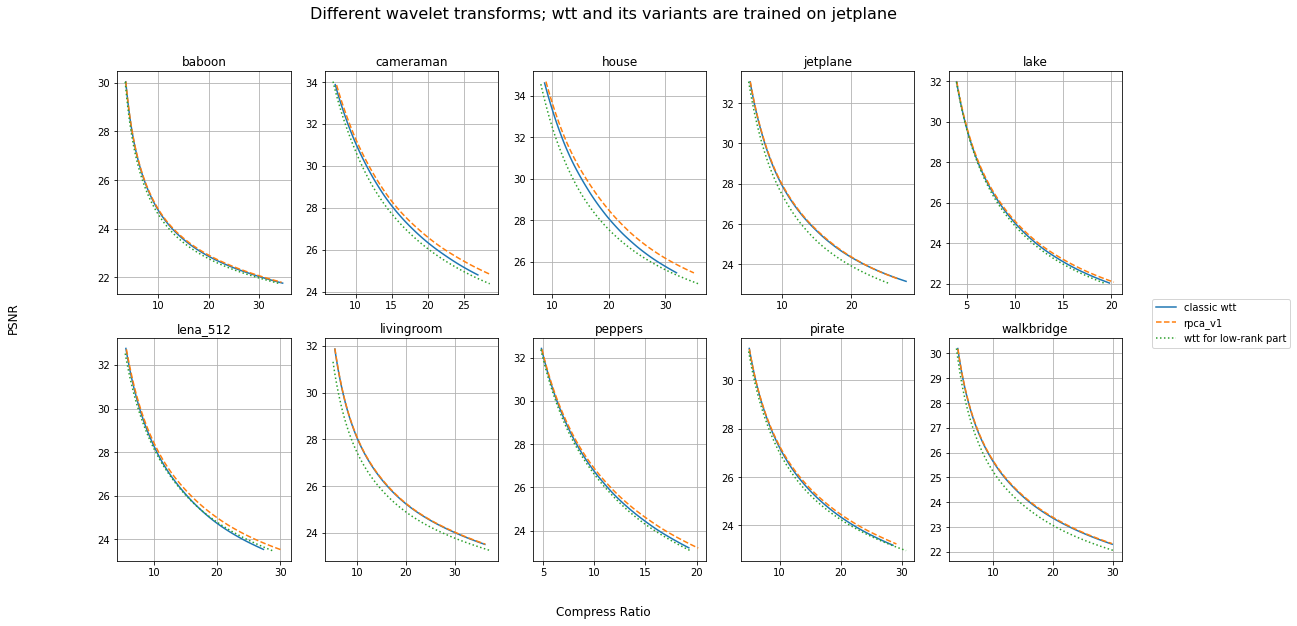

In [124]:
CR, PSNR = experiment(3, eps, lambda_scale)
plot_results(3, CR, PSNR,  window=[40, 160], algs_to_plot=[3, 4, 6], shape=[0,0,0,'-','--',0,':'])

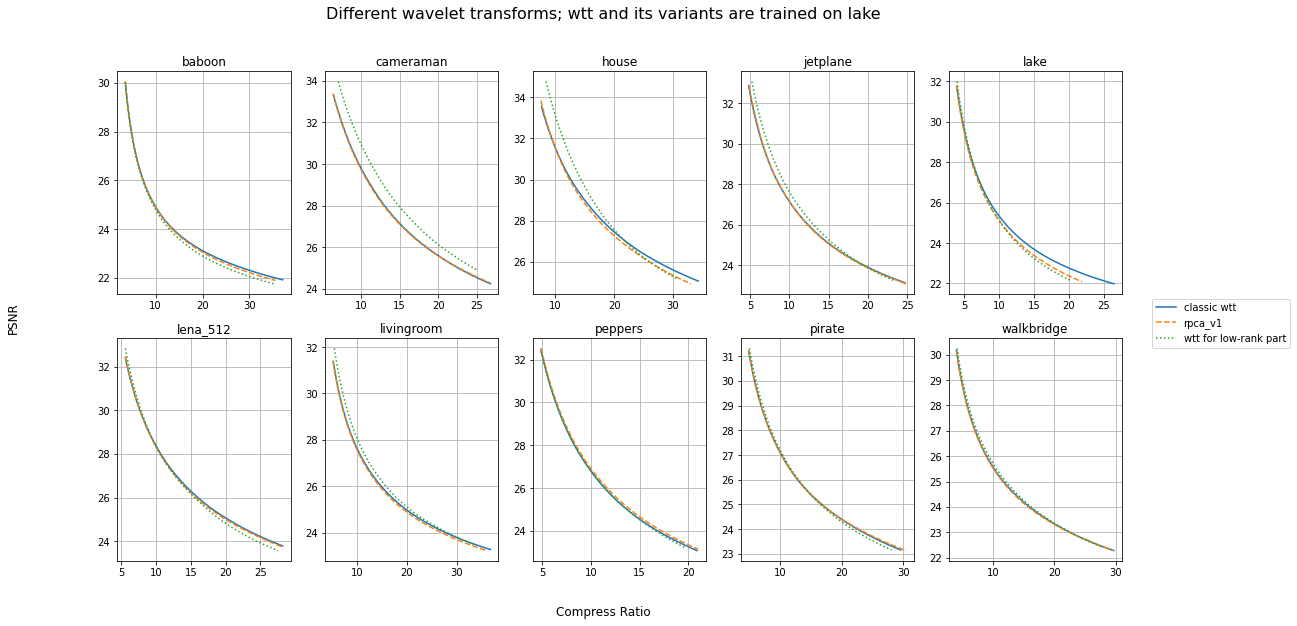

In [125]:
CR, PSNR = experiment(4, eps, lambda_scale)
plot_results(4, CR, PSNR,  window=[40, 160], algs_to_plot=[3, 4, 6], shape=[0,0,0,'-','--',0,':'])

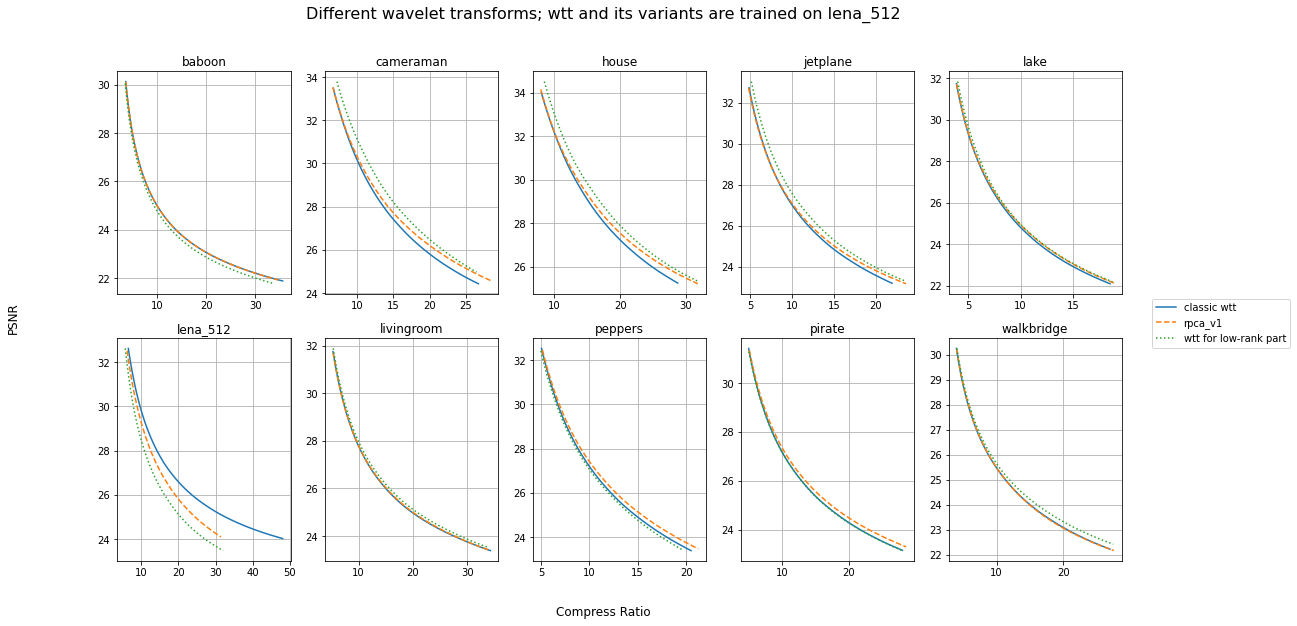

In [126]:
CR, PSNR = experiment(5, eps, lambda_scale)
plot_results(5, CR, PSNR, window=[40, 160], algs_to_plot=[3, 4, 6], shape=[0,0,0,'-','--',0,':'])

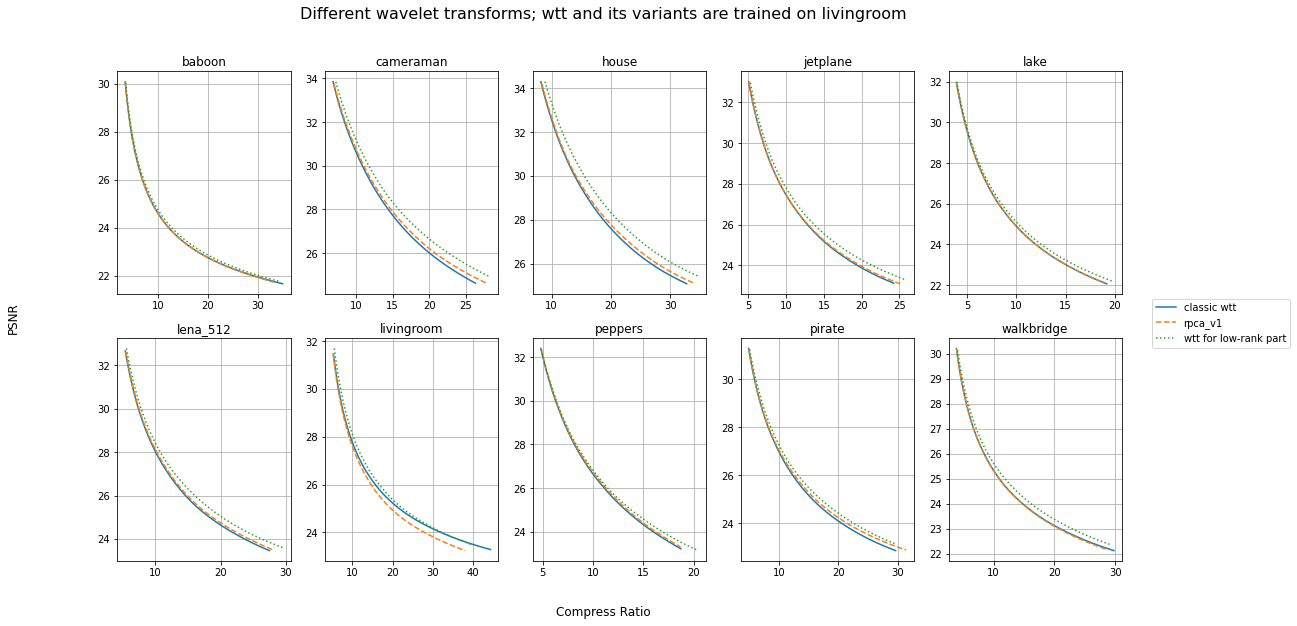

In [127]:
CR, PSNR = experiment(6, eps, lambda_scale)
plot_results(6, CR, PSNR, window=[40, 160], algs_to_plot=[3, 4, 6], shape=[0,0,0,'-','--',0,':'])

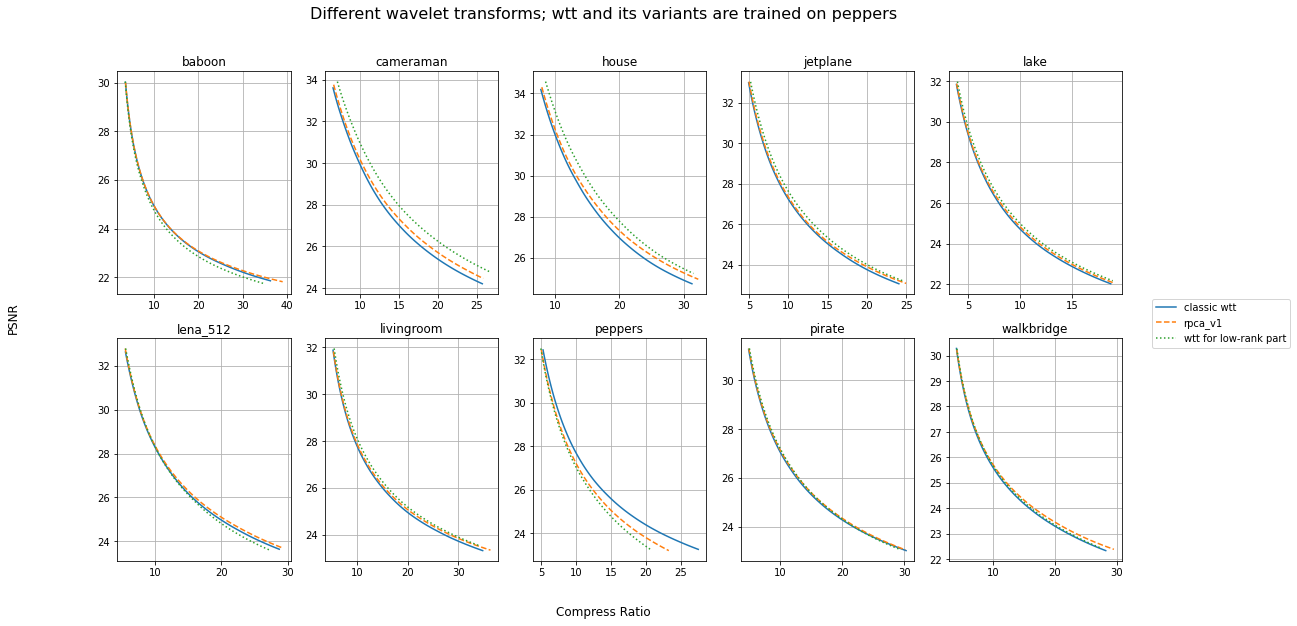

In [128]:
CR, PSNR = experiment(7, eps, lambda_scale)
plot_results(7, CR, PSNR, window=[40, 160], algs_to_plot=[3, 4, 6], shape=[0,0,0,'-','--',0,':'])

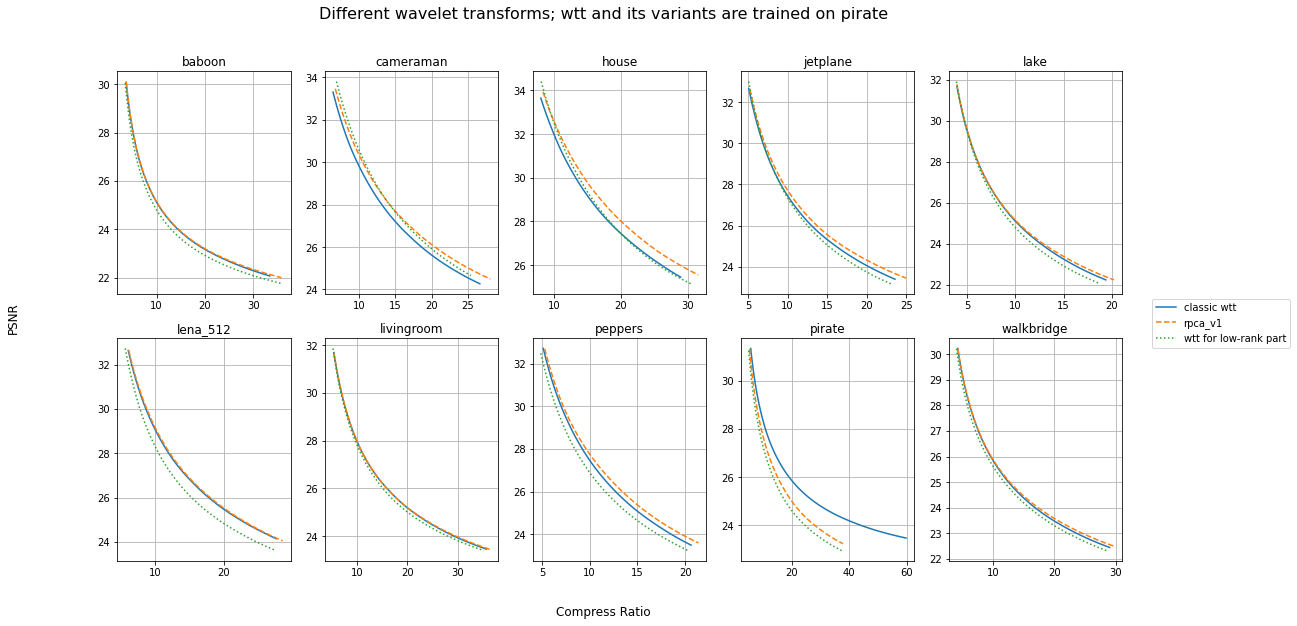

In [129]:
CR, PSNR = experiment(8, eps, lambda_scale)
plot_results(8, CR, PSNR, window=[40, 160], algs_to_plot=[3, 4, 6], shape=[0,0,0,'-','--',0,':'])

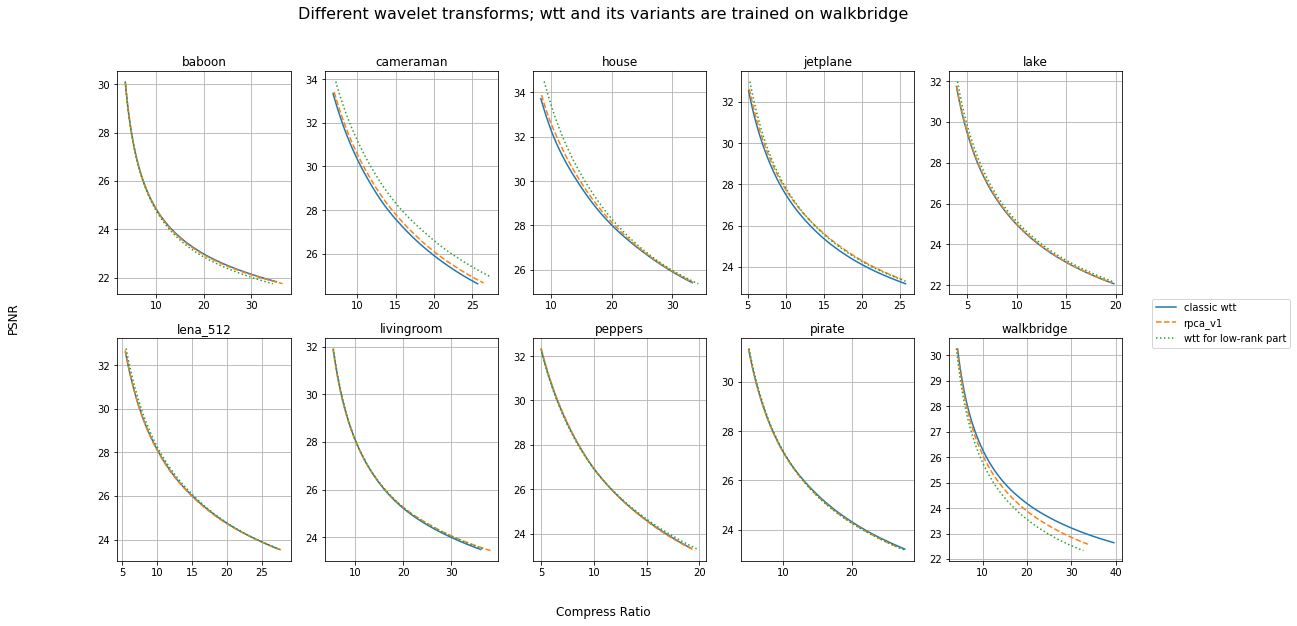

In [130]:
CR, PSNR = experiment(9, eps, lambda_scale)
plot_results(9, CR, PSNR, window=[40, 160], algs_to_plot=[3, 4, 6], shape=[0,0,0,'-','--',0,':'])

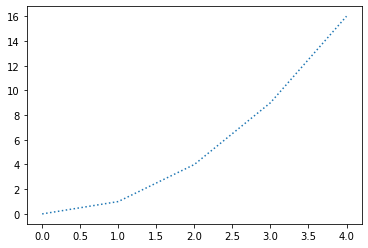

In [74]:
plt.plot(np.arange(5), np.arange(5) ** 2, ':')

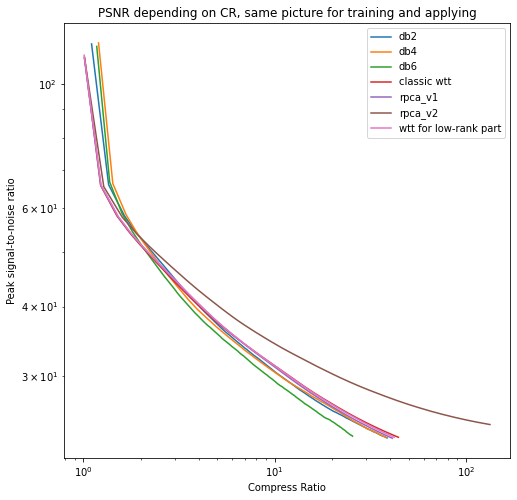

In [233]:
plt.figure(figsize=(8,8))
alg_names = db_names + ['classic wtt', 'rpca_v1', 'rpca_v2', 'wtt for low-rank part']

for i in range(len(alg_names)):
    plt.plot(CR[i], PSNR[i], label=alg_names[i])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Compress Ratio')
plt.ylabel('Peak signal-to-noise ratio')
plt.title('PSNR depending on CR, same picture for training and applying')
plt.legend()
plt.show()

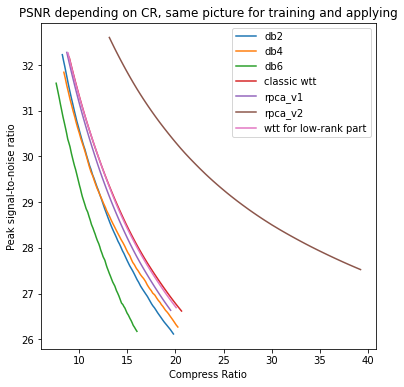

In [235]:
plt.figure(figsize=(6,6))
alg_names = db_names + ['classic wtt', 'rpca_v1', 'rpca_v2', 'wtt for low-rank part']

for i in range(len(alg_names)):
    plt.plot(CR[i][50:120], PSNR[i][50:120], label=alg_names[i])
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Compress Ratio')
plt.ylabel('Peak signal-to-noise ratio')
plt.title('PSNR depending on CR, same picture for training and applying')
plt.legend()
plt.show()

Попробуем теперь применить к другой картинке:

In [236]:
original = dataset_new[4]

CR = [[] for _ in range(len(dbs) + len(algs))]
PSNR = [[] for _ in range(len(dbs) + len(algs))]

coeffs_db = []
coeffs = []
for db in dbs:
    coeffs_db.append(pywt.wavedec2(original, db, mode='periodic'))
for w in algs:
    coeffs.append(w.apply(original, is_2D=True))

for delta in deltas:
    for i in range(len(dbs)):
        arr, slc = pywt.coeffs_to_array(coeffs_db[i])        
        thresholded = pywt.threshold(arr, delta, mode='hard')
        nnz = np.count_nonzero(thresholded)
        if nnz == 0:
            print('div by zero in cr')
            print('dbs, number=', i, 'delta=', delta)
        CR[i].append(thresholded.size * 1.0 / nnz)
        
        restored_coeffs = pywt.array_to_coeffs(thresholded, slc, output_format='wavedec2')
        restored = pywt.waverec2(restored_coeffs, dbs[i], mode='periodic')
        if nnz == original.size:
            print('div by zero in psnr')
            print('dbs, number=', i, 'delta=', delta)
        psnr_value = utils.psnr(original, restored)
        PSNR[i].append(psnr_value)
        
    for i in range(len(algs)):
        j = i + len(dbs)
        thresholded = pywt.threshold(coeffs[i], delta, mode='hard')
        nnz = np.count_nonzero(thresholded)
        if nnz == 0:
            print('div by zero in cr')
            print('wtts, number =', i, 'delta=', delta)
        CR[j].append(original.size * 1.0 / nnz)
        
        restored = algs[i].apply_inverse(thresholded, is_2D=True)
        if nnz == original.size:
            print('div by zero in psnr')
            print('wtts, number =', i, 'delta=', delta)
        psnr_value = utils.psnr(original, restored)
        PSNR[j].append(psnr_value)

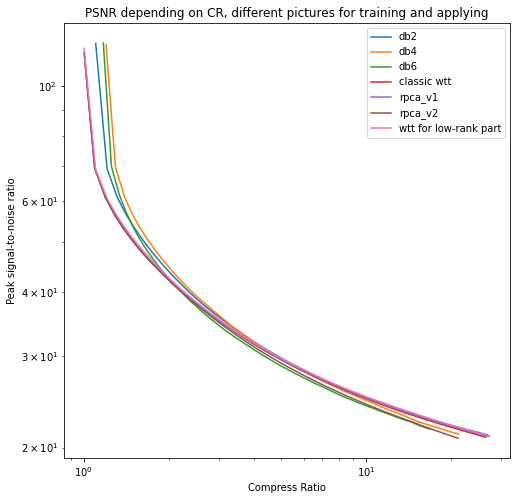

In [237]:
plt.figure(figsize=(8,8))
alg_names = db_names + ['classic wtt', 'rpca_v1', 'rpca_v2', 'wtt for low-rank part']

for i in range(len(alg_names)):
    plt.plot(CR[i], PSNR[i], label=alg_names[i])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Compress Ratio')
plt.ylabel('Peak signal-to-noise ratio')
plt.title('PSNR depending on CR, different pictures for training and applying')
plt.legend()
plt.show()

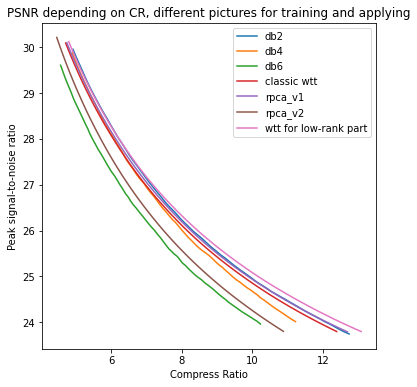

In [239]:
plt.figure(figsize=(6,6))
alg_names = db_names + ['classic wtt', 'rpca_v1', 'rpca_v2', 'wtt for low-rank part']

for i in range(len(alg_names)):
    plt.plot(CR[i][50:120], PSNR[i][50:120], label=alg_names[i])
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Compress Ratio')
plt.ylabel('Peak signal-to-noise ratio')
plt.title('PSNR depending on CR, different pictures for training and applying')
plt.legend()
plt.show()

In [250]:
original = dataset_new[2]

CR = [[] for _ in range(len(dbs) + len(algs))]
PSNR = [[] for _ in range(len(dbs) + len(algs))]

coeffs_db = []
coeffs = []
for db in dbs:
    coeffs_db.append(pywt.wavedec2(original, db, mode='periodic'))
for w in algs:
    coeffs.append(w.apply(original, is_2D=True))

for delta in deltas:
    for i in range(len(dbs)):
        arr, slc = pywt.coeffs_to_array(coeffs_db[i])        
        thresholded = pywt.threshold(arr, delta, mode='hard')
        nnz = np.count_nonzero(thresholded)
        if nnz == 0:
            print('div by zero in cr')
            print('dbs, number=', i, 'delta=', delta)
        CR[i].append(thresholded.size * 1.0 / nnz)
        
        restored_coeffs = pywt.array_to_coeffs(thresholded, slc, output_format='wavedec2')
        restored = pywt.waverec2(restored_coeffs, dbs[i], mode='periodic')
        if nnz == original.size:
            print('div by zero in psnr')
            print('dbs, number=', i, 'delta=', delta)
        psnr_value = utils.psnr(original, restored)
        PSNR[i].append(psnr_value)
        
    for i in range(len(algs)):
        j = i + len(dbs)
        thresholded = pywt.threshold(coeffs[i], delta, mode='hard')
        nnz = np.count_nonzero(thresholded)
        if nnz == 0:
            print('div by zero in cr')
            print('wtts, number =', i, 'delta=', delta)
        CR[j].append(original.size * 1.0 / nnz)
        
        restored = algs[i].apply_inverse(thresholded, is_2D=True)
        if nnz == original.size:
            print('div by zero in psnr')
            print('wtts, number =', i, 'delta=', delta)
        psnr_value = utils.psnr(original, restored)
        PSNR[j].append(psnr_value)

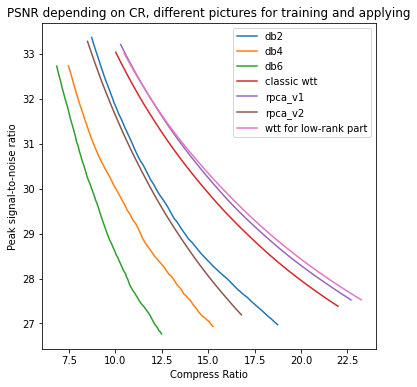

In [251]:
plt.figure(figsize=(6,6))
alg_names = db_names + ['classic wtt', 'rpca_v1', 'rpca_v2', 'wtt for low-rank part']

for i in range(len(alg_names)):
    plt.plot(CR[i][50:120], PSNR[i][50:120], label=alg_names[i])
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Compress Ratio')
plt.ylabel('Peak signal-to-noise ratio')
plt.title('PSNR depending on CR, different pictures for training and applying')
plt.legend()
plt.show()

Попробуем внедрить препроцессинг.

Идея: вдруг мы, обучив фильтры на малоранговой части, сможем получить более универсальные фильтры для других изображений?

In [ ]:
CR_new = [[] for _ in range(2)]
PSNR_new = [[] for _ in range(2)]

original = dataset_new[1]
coeffs_1 = wtt_for_preproc.apply(original, is_2D=True)
original = dataset_new[4]
coeffs_2 = wtt_for_preproc.apply(original, is_2D=True)

for delta in deltas:
    thresholded = pywt.threshold(coeffs_1, delta, mode='hard')
    nnz = np.count_nonzero(thresholded)
    if nnz == 0:
        print('div by zero in cr')
        print('wtts, number =', i, 'delta=', delta)
    CR_new[0].append(original.size * 1.0 / nnz)

    restored = algs[i].apply_inverse(thresholded, is_2D=True)
    if nnz == original.size:
        print('div by zero in psnr')
        print('wtts, number =', i, 'delta=', delta)
    psnr_value = utils.psnr(original, restored)
    PSNR_new[0].append(psnr_value)
    
    thresholded = pywt.threshold(coeffs_2, delta, mode='hard')
    nnz = np.count_nonzero(thresholded)
    if nnz == 0:
        print('div by zero in cr')
        print('wtts, number =', i, 'delta=', delta)
    CR_new[1].append(original.size * 1.0 / nnz)

    restored = algs[i].apply_inverse(thresholded, is_2D=True)
    if nnz == original.size:
        print('div by zero in psnr')
        print('wtts, number =', i, 'delta=', delta)
    psnr_value = utils.psnr(original, restored)
    PSNR_new[0].append(psnr_value)

In [131]:
#https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
#вообще, наверное, есть более-менее строгое определение, но я его не нашёл

def sp_noise(image, prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape, np.uint8)
    thres = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = np.random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

In [132]:
def experiment_noise(
    original_num,
    eps_for_wtt,
    lambda_scale
):
    original = dataset_new[original_num]
    original = sp_noise(original, 0.008)
    
    db_names = ['db2', 'db4', 'db6']
    dbs = [pywt.Wavelet(name) for name in db_names]
    wtt_classic = wrappers.WTTwrapper(1) #классика
    wtt_rpca_1 = wrappers.WTTwrapper(2) #просто RPCA вместо SVD
    wtt_rpca_2 = wrappers.WTTwrapper(3) #RPCA с сохранением sparse-частей

    algs = [
        wtt_classic,
        wtt_rpca_1,
        wtt_rpca_2
    ]

    for w in algs:
        w.adjust(
            original,
            d,
            modes,
            eps=eps,
            lambda_scale=lambda_scale,
            is_2D=True
        )

    preproc = wrappers.RPCA_preprocessing_wrapper(2)
    wtt_for_preproc = wrappers.WTTwrapper(1)

    vector, vector_modes = utils.matrix_to_vector(original, d, modes)
    l, s, r = preproc.adjust(
        vector,
        d,
        vector_modes,
        lambda_scale=lambda_scale,
        max_iter=150
    )
    l_matrix = utils.vector_to_matrix(l, d, vector_modes)[0]

    wtt_for_preproc.adjust(l_matrix, d, modes, ranks=r, eps=eps, is_2D=True)
    algs.append(wtt_for_preproc)

    deltas = np.linspace(1e-2, 1e2, 200)

    CR = [
        [[] for _ in range(len(dbs) + len(algs))] for _ in range(dataset_new.shape[0])
    ]
    PSNR = [
        [[] for _ in range(len(dbs) + len(algs))] for _ in range(dataset_new.shape[0])
    ]

    for cnt in range(10):
        original = dataset_new[cnt]
        coeffs_db = []
        coeffs = []
        for db in dbs:
            coeffs_db.append(pywt.wavedec2(original, db, mode='periodic'))
        for w in algs:
            coeffs.append(w.apply(original, is_2D=True))

        for delta in deltas:
            for i in range(len(dbs)):
                arr, slc = pywt.coeffs_to_array(coeffs_db[i])        
                thresholded = pywt.threshold(arr, delta, mode='hard')
                nnz = np.count_nonzero(thresholded)
                if nnz == 0:
                    print('div by zero in cr')
                    print('dbs, number=', i, 'delta=', delta)
                CR[cnt][i].append(thresholded.size * 1.0 / nnz)

                restored_coeffs = pywt.array_to_coeffs(thresholded, slc, output_format='wavedec2')
                restored = pywt.waverec2(restored_coeffs, dbs[i], mode='periodic')
                if nnz == original.size:
                    print('div by zero in psnr')
                    print('dbs, number=', i, 'delta=', delta)
                psnr_value = utils.psnr(original, restored)
                PSNR[cnt][i].append(psnr_value)

            for i in range(len(algs)):
                j = i + len(dbs)
                thresholded = pywt.threshold(coeffs[i], delta, mode='hard')
                nnz = np.count_nonzero(thresholded)
                if nnz == 0:
                    print('div by zero in cr')
                    print('wtts, number =', i, 'delta=', delta)
                CR[cnt][j].append(original.size * 1.0 / nnz)

                restored = algs[i].apply_inverse(thresholded, is_2D=True)
                if nnz == original.size:
                    print('div by zero in psnr')
                    print('wtts, number =', i, 'delta=', delta)
                psnr_value = utils.psnr(original, restored)
                PSNR[cnt][j].append(psnr_value)

    return CR, PSNR

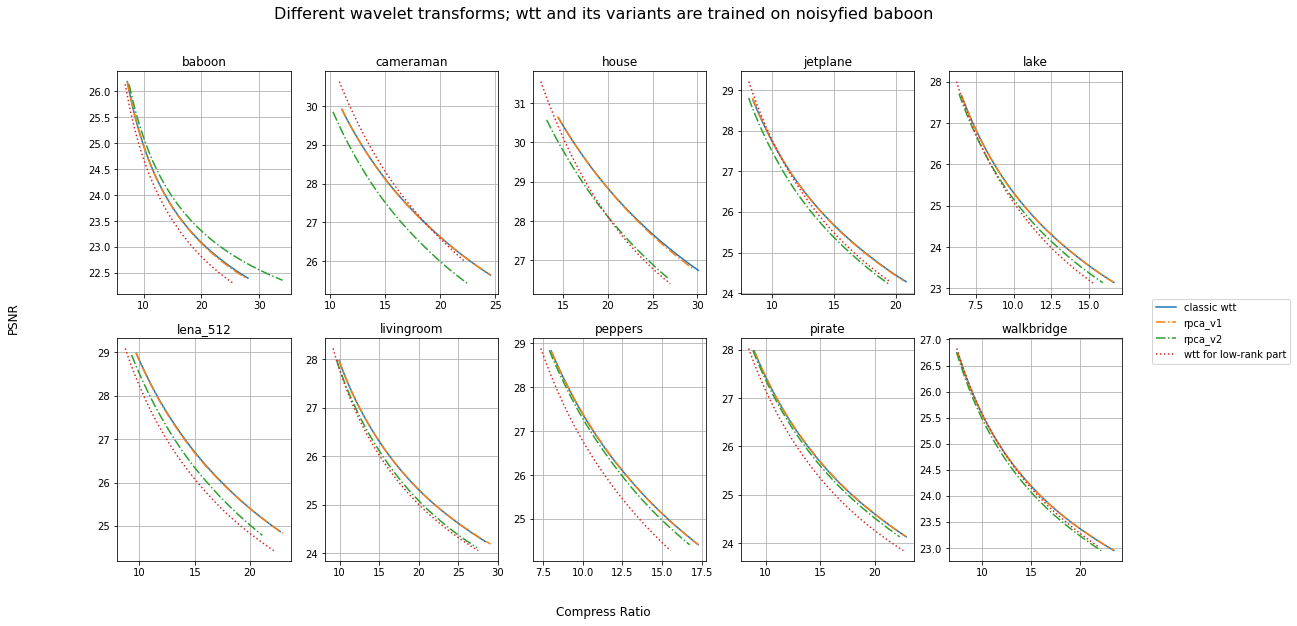

In [138]:
orig = 0
CR, PSNR = experiment_noise(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], algs_to_plot=[3,4,5,6], shape=['--','--','--','-','-.','-.',':'], noisy=True)

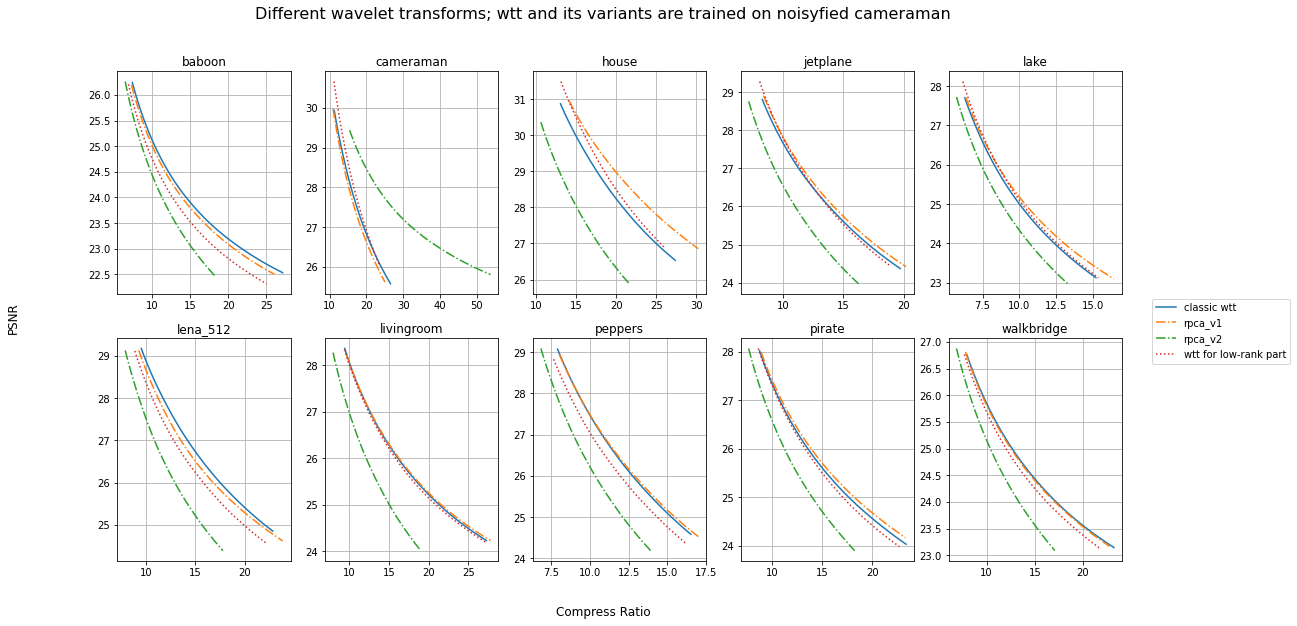

In [139]:
orig = 1
CR, PSNR = experiment_noise(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], algs_to_plot=[3,4,5,6], shape=['--','--','--','-','-.','-.',':'], noisy=True)

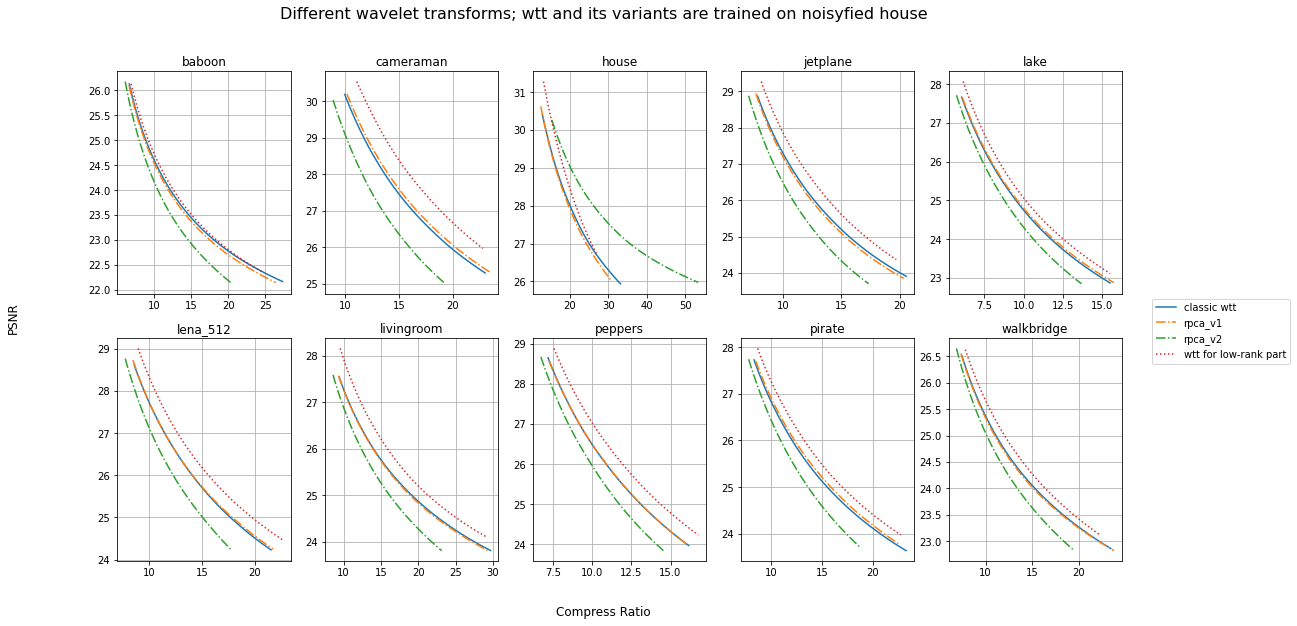

In [140]:
orig = 2
CR, PSNR = experiment_noise(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], algs_to_plot=[3,4,5,6], shape=['--','--','--','-','-.','-.',':'], noisy=True)

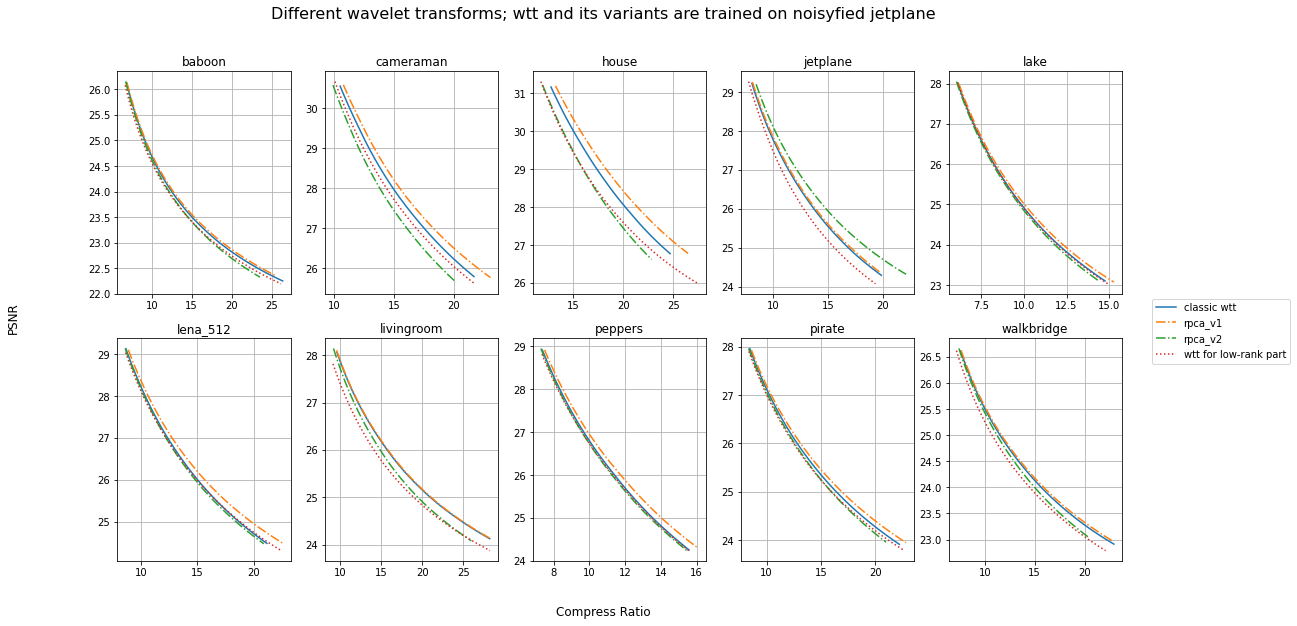

In [141]:
orig = 3
CR, PSNR = experiment_noise(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], algs_to_plot=[3,4,5,6], shape=['--','--','--','-','-.','-.',':'], noisy=True)

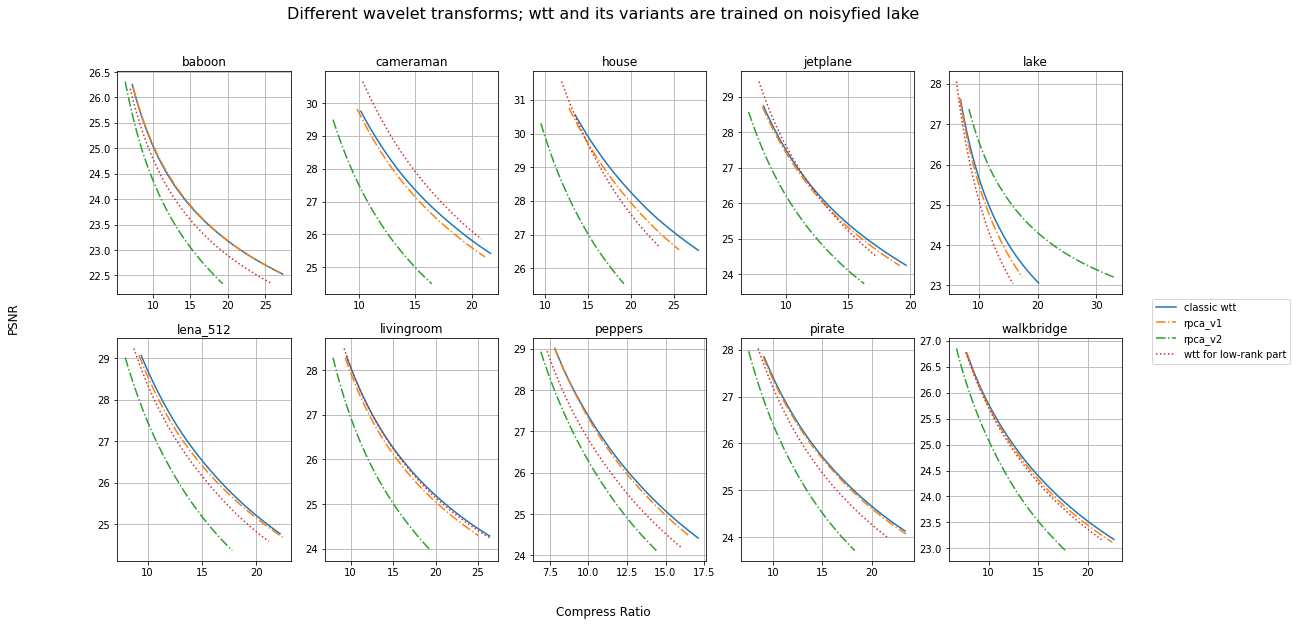

In [142]:
orig = 4
CR, PSNR = experiment_noise(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], algs_to_plot=[3,4,5,6], shape=['--','--','--','-','-.','-.',':'], noisy=True)

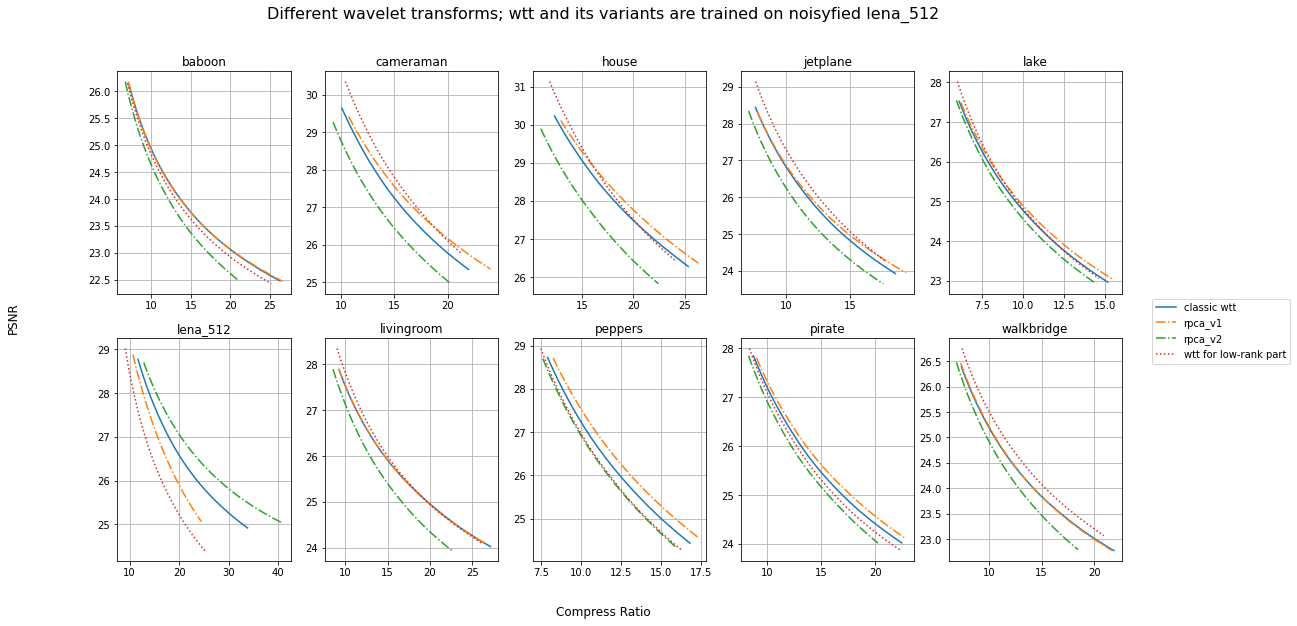

In [143]:
orig = 5
CR, PSNR = experiment_noise(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], algs_to_plot=[3,4,5,6], shape=['--','--','--','-','-.','-.',':'], noisy=True)

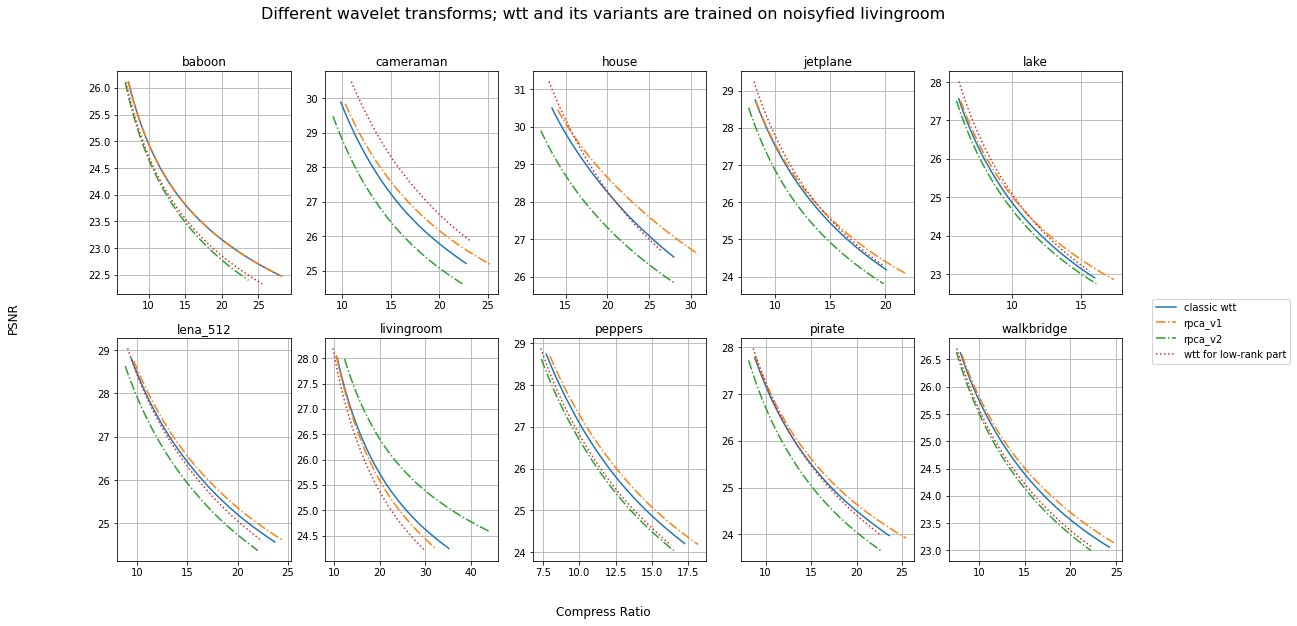

In [144]:
orig = 6
CR, PSNR = experiment_noise(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], algs_to_plot=[3,4,5,6], shape=['--','--','--','-','-.','-.',':'], noisy=True)

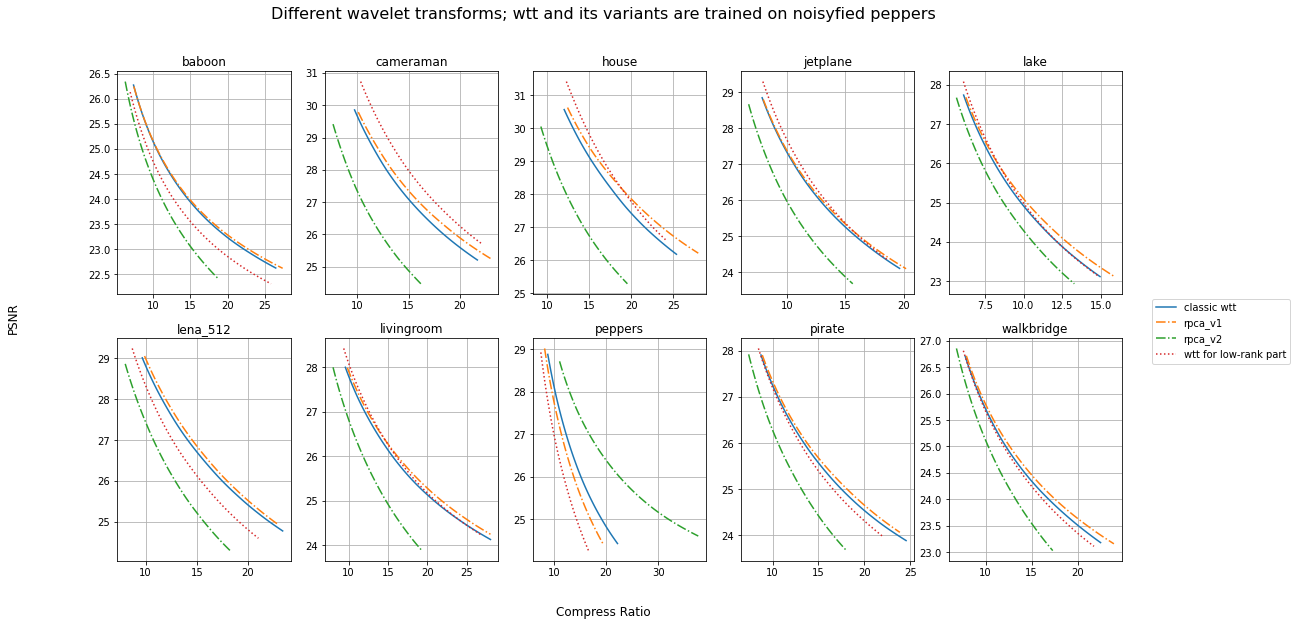

In [145]:
orig = 7
CR, PSNR = experiment_noise(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], algs_to_plot=[3,4,5,6], shape=['--','--','--','-','-.','-.',':'], noisy=True)

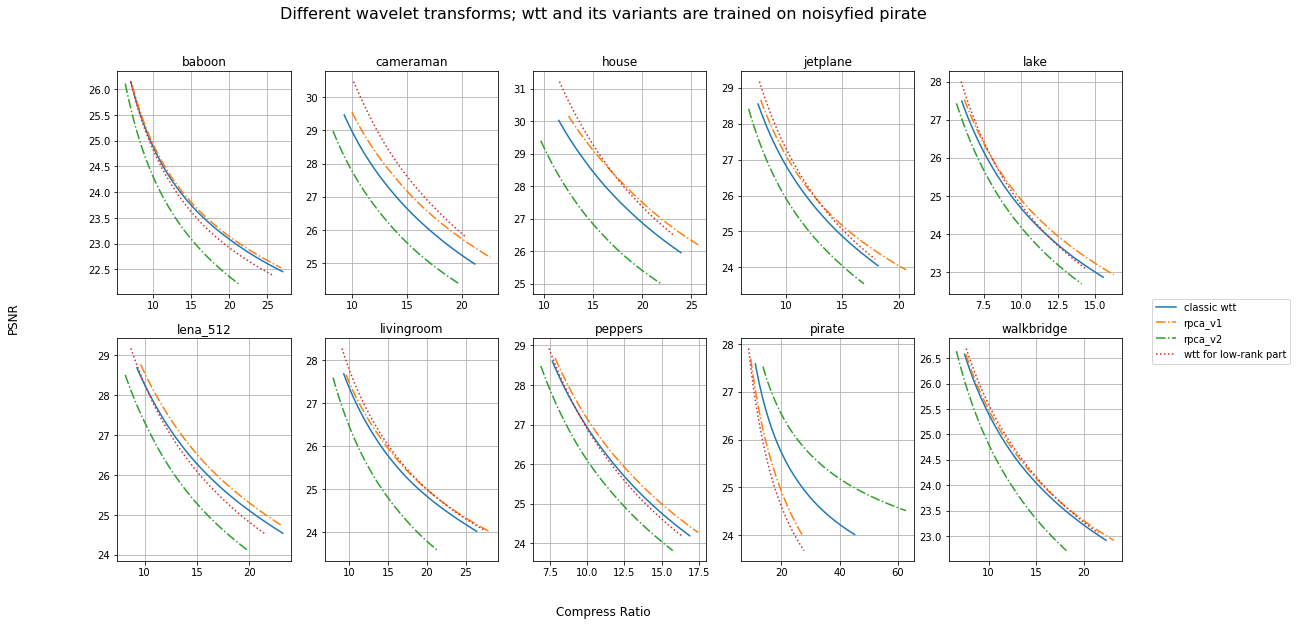

In [146]:
orig = 8
CR, PSNR = experiment_noise(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], algs_to_plot=[3,4,5,6], shape=['--','--','--','-','-.','-.',':'], noisy=True)

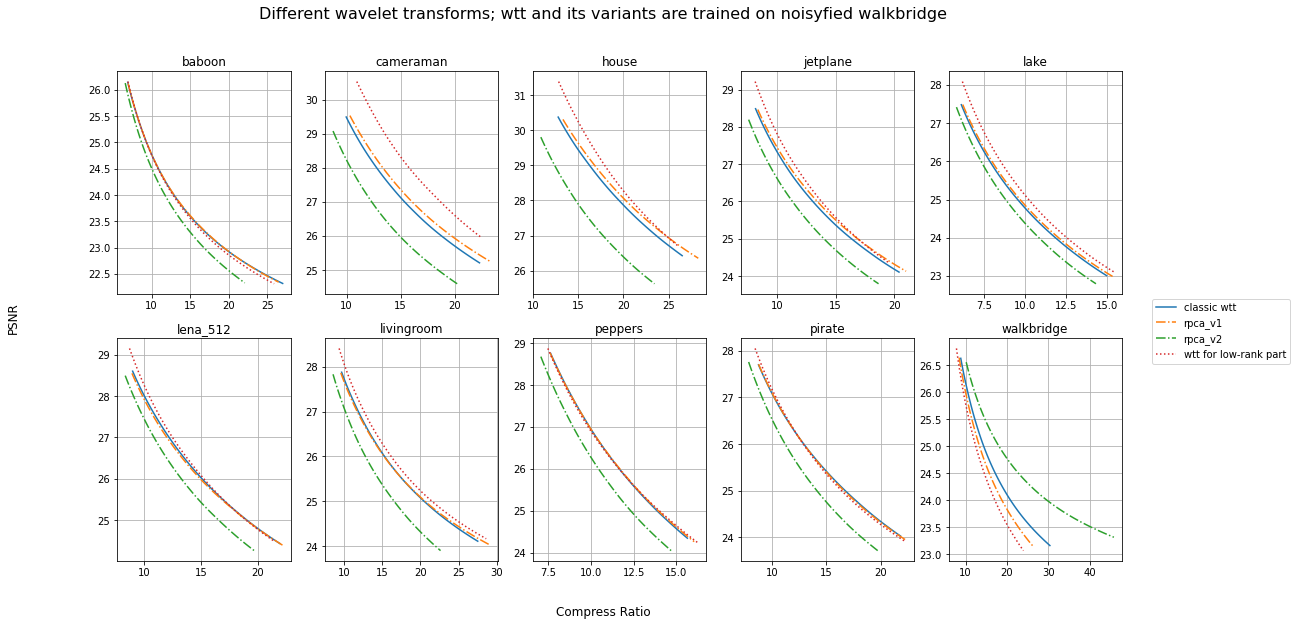

In [148]:
orig = 9
CR, PSNR = experiment_noise(orig, eps, lambda_scale)
plot_results(orig, CR, PSNR, window=[65, 135], algs_to_plot=[3,4,5,6], shape=['--','--','--','-','-.','-.',':'], noisy=True)